In [9]:
import boto3
import pandas as pd
from decimal import Decimal
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

from datetime import date

**Dynamo db**

In [5]:
# Inicializar un cliente de DynamoDB
dynamodb = boto3.resource('dynamodb')

# Seleccionar la tabla
table = dynamodb.Table('volatiliy_table')

response = table.scan()
data = response['Items']

# Convertir la lista de diccionarios a DataFrame
df = pd.DataFrame(data)

# Convertir todas las columnas que contienen decimales a flotantes
for column in ['Vol_call', 'Strike', 'Vol_put']:
    df[column] = df[column].apply(lambda x: float(x) if isinstance(x, Decimal) else x)
    
df = df.loc[:, ['Fecha', 'Strike', 'Vol_call', 'Vol_put']]

# Ordenar los datos primero por 'Fecha' y luego por 'Strike'
df = df.sort_values(by=['Fecha', 'Strike'])

# Resetear el índice del DataFrame
df = df.reset_index(drop=True)

# Reemplazar valores menores que 0.001 en 'Vol_call' y 'Vol_put' por NaN
df['Vol_call'] = df['Vol_call'].mask(df['Vol_call'] < 0.001, np.nan)
df['Vol_put'] = df['Vol_put'].mask(df['Vol_put'] < 0.001, np.nan)

In [7]:
unique_dates = df['Fecha'].unique()

In [13]:
unique_dates

array(['2024-05-03', '2024-05-10', '2024-05-17', '2024-05-24',
       '2024-06-21', '2024-07-19', '2024-09-20', '2024-12-20',
       '2025-03-21', '2025-06-20', '2025-12-19'], dtype=object)

In [14]:
# Obtenemos la fecha actual en formato de cadena (string)
today = str(date.today())

# Filtramos para excluir la fecha de hoy
filtered_dates = unique_dates[unique_dates != today]

# Convertimos el resultado final a un arreglo de NumPy con dtype object
filtered_dates_array = np.array(filtered_dates, dtype=object)

In [15]:
filtered_dates_array

array(['2024-05-10', '2024-05-17', '2024-05-24', '2024-06-21',
       '2024-07-19', '2024-09-20', '2024-12-20', '2025-03-21',
       '2025-06-20', '2025-12-19'], dtype=object)

In [11]:
# Obtenemos la fecha actual en formato de cadena (string)
today = str(date.today())

# Filtramos para excluir la fecha de hoy
filtered_dates = unique_dates[unique_dates != today]

# Convertimos el resultado final a una lista
filtered_dates = filtered_dates.tolist()



In [12]:
filtered_dates

['2024-05-10',
 '2024-05-17',
 '2024-05-24',
 '2024-06-21',
 '2024-07-19',
 '2024-09-20',
 '2024-12-20',
 '2025-03-21',
 '2025-06-20',
 '2025-12-19']

In [61]:
# Filtrar para obtener solo las filas de la fecha 2024-05-03
filtered_df = df[df['Fecha'] == '2024-05-03']

In [63]:
filtered_df.loc[:, ['Strike', 'Vol_call']]

,Strike,Vol_call
0,10500.0,NaN
1,10600.0,0.529424
2,10700.0,0.166559
3,10750.0,NaN
4,10800.0,NaN
5,10850.0,0.066678
6,10900.0,0.230456
7,10950.0,0.165624
8,10975.0,0.237181
9,11000.0,0.235885


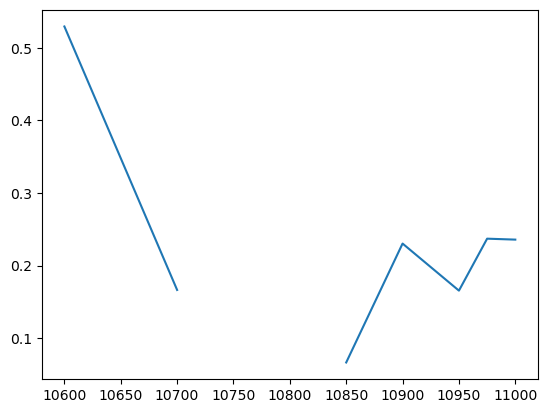

In [64]:
plt.figure()
plt.plot(filtered_df.Strike, filtered_df.Vol_call)
plt.show()

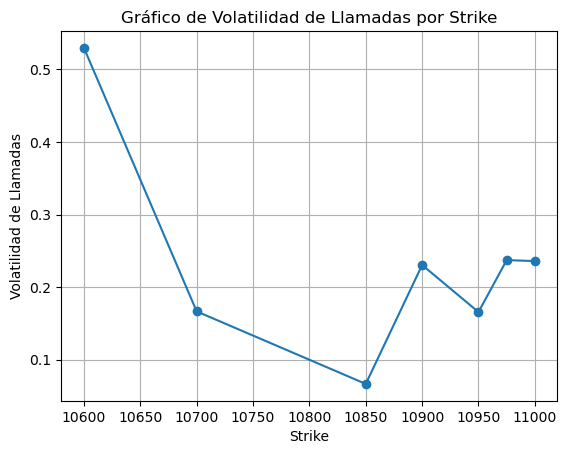

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# Simulando la lectura de tus datos
data = """
Strike	Vol_call
10500.0	NaN
10600.0	0.529424
10700.0	0.166559
10750.0	NaN
10800.0	NaN
10850.0	0.066678
10900.0	0.230456
10950.0	0.165624
10975.0	0.237181
11000.0	0.235885
"""
df = pd.read_csv(StringIO(data), sep="\t")

# Eliminar filas donde 'Vol_call' es NaN antes de graficar
df_clean = df.dropna(subset=['Vol_call'])

# Graficar los datos limpios
plt.figure()
plt.plot(df_clean.Strike, df_clean.Vol_call, marker='o')  # Usando marcadores para visualizar puntos
plt.title("Gráfico de Volatilidad de Llamadas por Strike")
plt.xlabel("Strike")
plt.ylabel("Volatilidad de Llamadas")
plt.grid(True)  # Añade una cuadrícula para mejor visualización
plt.show()

In [51]:
pd.read_csv('volatilidades_new.csv')

,Fecha,Strike,Vol_call,Vol_put
0,2024-05-03,10500.0,NaN,0.328447
1,2024-05-03,10600.0,0.530891,NaN
2,2024-05-03,10700.0,0.170790,0.290064
3,2024-05-03,10750.0,NaN,0.282927
4,2024-05-03,10800.0,NaN,0.225580
...,...,...,...,...
94,2024-12-20,10700.0,0.153894,NaN
95,2024-12-20,11400.0,0.144506,NaN
96,2024-12-20,11500.0,0.156558,NaN
97,2025-06-20,11500.0,0.146928,NaN


In [37]:

df = pd.read_csv('volatilidades.csv')

print(df)


         Fecha   Strike  Vol_call   Vol_put
0   2024-05-03  10600.0       NaN       NaN
1   2024-05-03  10650.0       NaN  0.265461
2   2024-05-03  10700.0       NaN       NaN
3   2024-05-03  10750.0       NaN  0.257124
4   2024-05-03  10800.0       NaN  0.252691
..         ...      ...       ...       ...
82  2024-12-20  11300.0  0.147170       NaN
83  2024-12-20  11400.0  0.146287       NaN
84  2024-12-20  11500.0  0.145415       NaN
85  2025-03-21  10600.0       NaN  0.156742
86  2025-06-20  11500.0  0.148478       NaN

[87 rows x 4 columns]


**S3**

In [47]:
# Crear un cliente S3
s3 = boto3.client('s3')

# Definir el nombre del bucket y la clave del archivo
bucket_name = 'miax-12-scrap-meff'
file_key = 'datos_futuros.json'

# Obtener el objeto S3
response = s3.get_object(Bucket=bucket_name, Key=file_key)

# Leer el contenido del objeto
file_content = response['Body'].read()

# Convertir bytes a un objeto similar a un archivo usando BytesIO
json_bytes = BytesIO(file_content)

# Cargar el contenido del objeto BytesIO en un DataFrame
df_futuro = pd.read_json(json_bytes)

precio_subyacente = df_futuro.loc[0, 'Ant']

In [45]:
# Crear un cliente S3
s3 = boto3.client('s3')

# Definir el nombre del bucket y la clave del archivo
bucket_name = 'miax-12-scrap-meff'
file_key = 'datos_opciones.json'

# Obtener el objeto S3
response = s3.get_object(Bucket=bucket_name, Key=file_key)

# Leer el contenido del objeto
file_content = response['Body'].read()

# Convertir bytes a un objeto similar a un archivo usando BytesIO
json_bytes = BytesIO(file_content)

# Cargar el contenido del objeto BytesIO en un DataFrame
df_opciones = pd.read_json(json_bytes)


In [46]:
df_opciones

,Tipo_x,Fecha,Strike,Buy_price_call,Sell_price_call,Ant_call,Tipo_y,Buy_price_put,Sell_price_put,Ant_put,T,Precio_call,Precio_put
0,None,2024-05-03,10500,NaN,NaN,NaN,OPE,NaN,2.0,1.0,0.002738,NaN,2.0
1,OCE,2024-05-03,10600,NaN,283.0,241.0,None,NaN,NaN,NaN,0.002738,283.0,NaN
2,OCE,2024-05-03,10700,NaN,NaN,152.0,OPE,NaN,NaN,16.0,0.002738,152.0,16.0
3,None,2024-05-03,10750,NaN,NaN,NaN,OPE,NaN,NaN,26.0,0.002738,NaN,26.0
4,None,2024-05-03,10800,NaN,NaN,NaN,OPE,NaN,30.0,42.0,0.002738,NaN,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,OCE,2024-12-20,10700,NaN,NaN,605.0,None,NaN,NaN,NaN,0.635181,605.0,NaN
95,OCE,2024-12-20,11400,NaN,NaN,282.0,None,NaN,NaN,NaN,0.635181,282.0,NaN
96,OCE,2024-12-20,11500,NaN,290.0,249.0,None,NaN,NaN,NaN,0.635181,290.0,NaN
97,OCE,2025-06-20,11500,NaN,NaN,419.0,None,NaN,NaN,NaN,1.133470,419.0,NaN


In [31]:
precio_subyacente

10849.5